# Лабораторная работа 4

## Практика TensorFlow 2.x

Выполнил: 6233-010402В, Борисов Д.С.

### Задание

В данной лабораторной работе будет практиковаться материал из лекций по TensorFlow на примере решения задачи классификации изображений из датасета Fashion MNIST. Fashion MNIST - набор черно-белых изображений размера 28х28, что поделены на 10 классов. Будет построена с нуля и обучена модель логистической регрессии используя как низкоуровневый API. Опционально решение той же задачи нейронной сетью, построенной и обученной с использованием Keras.

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from tqdm import tqdm

0 Базовые операции. 
   - 0.1 Сгенерируйте три непересекающихся гауссовых облака, используя `tf.random`. Визуализируйте их разными цветами, используя matplotlib. 
   - 0.2 Сгенерируйте случайную матрицу 2x2, умножьте каждую точку в облаках на эту матрицу. Повторно визуализируйте облака.

In [2]:
# 0.1
N_points = 100

cloud1 = tf.random.normal((N_points, 2), mean=[1, 1], stddev=1)
cloud2 = tf.random.normal((N_points, 2), mean=[10, 5], stddev=1)
cloud3 = tf.random.normal((N_points, 2), mean=[5, 10], stddev=1)

cloud_vstack = np.vstack([cloud1, cloud2, cloud3])

labels = [0]*N_points + [1]*N_points + [2]*N_points

df_data = pd.DataFrame(data=cloud_vstack, index=labels, columns=['x', 'y'])

In [3]:
df_data

,x,y
0,-0.030459,1.557909
0,1.726860,2.058536
0,1.244979,0.723491
0,1.959969,0.919227
0,0.269715,2.867544
...,...,...
2,3.967207,9.712507
2,5.954034,7.980791
2,5.007346,7.843644
2,6.003503,11.068775


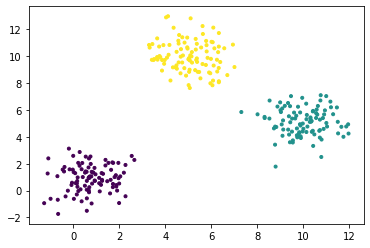

In [4]:
plt.scatter(df_data['x'], df_data['y'], c=labels, marker=".")

In [5]:
# 0.2
matrix = tf.random.normal((2, 2))
print(matrix)

tf.Tensor(
[[ 0.5817414   0.9613957 ]
 [-0.60136443 -1.3269057 ]], shape=(2, 2), dtype=float32)


In [6]:
new_clouds = df_data.dot(matrix)
new_clouds

,0,1
0,-0.954590,-2.096482
0,-0.233344,-1.071287
0,0.289174,0.236913
0,0.587404,0.664578
0,-1.567535,-3.545658
...,...,...
2,-3.532868,-9.073525
2,-1.335656,-4.865575
2,-1.803908,-5.593736
2,-3.163881,-8.915479


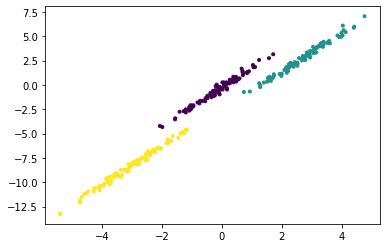

In [7]:
plt.scatter(new_clouds[0], new_clouds[1], c=labels, marker=".")

1 Загрузите датасет Fashion MNIST, используя метод из [tf.keras.datasets](https://www.tensorflow.org/api_docs/python/tf/keras/datasets). Визуализируйте несколько изображений, используя библиотеку matplotlib.

In [8]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

X_train.shape, y_train.shape, X_test.shape, y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [9]:
X_train = X_train.astype('float32')
X_test = X_test.astype('float32')

y_train = y_train.astype('int32')
y_test = y_test.astype('int32')

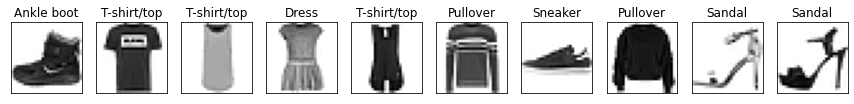

In [10]:
plt.figure(figsize=(15,20))
for i in range(len(class_names)):
    ax = plt.subplot(1,len(class_names),i+1)
    ax.imshow(X_train[i], cmap='binary')
    ax.set_title(class_names[y_train[i]])
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()

2 Нормализуйте данные либо средним и СКО, либо приведя значения пикселей в интервал [-1, 1].

In [11]:
mean, std = np.mean(X_train), np.std(X_train)
mean, std

(72.94042, 90.02121)

In [12]:
X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

In [13]:
np.mean(X_train), np.std(X_train)

(-7.9631286e-07, 1.0000011)

3 Создайте обучающий и тестовый TensorFlow Dataset из нормализованного набора данных. К обучающему датасету добавьте перемешивание (`.shuffle`). К обоим датасетам добавьте генерацию батчей размера 128 (`.batch(128)`).

In [14]:
train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
test_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))

train_dataset = train_dataset.shuffle(buffer_size=len(X_train), reshuffle_each_iteration=True)
test_dataset = test_dataset.shuffle(buffer_size=len(X_test), reshuffle_each_iteration=True)

train_dataset = train_dataset.batch(128, drop_remainder=True)
test_dataset = test_dataset.batch(128, drop_remainder=True)

4 Напишите класс слоя `Flatten`, что трансформирует изображения из матричного в векторный вид: [28, 28] -> [28 * 28]. Класс слоя должен наследоваться от `tf.Module`. Для трансформации тензоров изображений использовать `tf.reshape`.

In [15]:
class Flatten(tf.Module):

    def __init__(self, name=None):
        super().__init__(name=name)

    def __call__(self, data):
        old_shape = tf.shape(data)
        if len(old_shape) == 1:
            new_shape = old_shape
        elif len(old_shape) == 2:
            new_shape = (1, tf.math.reduce_prod(old_shape))
        else:
            new_shape = (old_shape[0], tf.math.reduce_prod(old_shape[1:]))
        return tf.reshape(data, new_shape)

5 Напишите класс линейного слоя `Linear`, что умножает входной вектор на матрицу весов. Класс слоя должен наследоваться от `tf.Module`. Матрицу весов хранить в `tf.Variable`. Параметры конструктора: `in_d` - размерность входного вектора, `out_d` - размерность выходного вектора. В качестве начальной инициализации весов использовать гауссово распределение с СКО=0.01.

In [16]:
class Linear(tf.Module):
    def __init__(self, in_d, out_d, name=None):
        super().__init__(name=name)
        w = tf.random.normal(shape=[in_d, out_d], stddev=0.01, dtype='float32')
        self.w = tf.Variable(w, 
                             name='weights' if name is None else f'{name}_weights')
        self.b = tf.Variable(tf.zeros(out_d, dtype='float32'), 
                             name='bias' if name is None else f'{name}_bias')
        
    def __call__(self, x):
        return tf.matmul(x, self.w) + self.b

6 Напишите класс модели логистической регрессии `LogisticRegression`, что компонует в себе слои `Linear` и `Flatten`. Класс модели должен наследоваться от `tf.Module`. В качестве функции активации используйте `tf.nn.softmax`.
Создайте объект модели и попробуйте с помощью неё классифицировать одно изображение (не забудьте о размерности батча! Она будет равна 1).

In [17]:
class LogisticRegression(tf.Module):
    def __init__(self, in_d, out_d=10, name='logistic_regression'):
        super().__init__(name=name)

        self.flatten = Flatten(name=f'{name}_flatten')
        self.linear = Linear(in_d, out_d, name=f'{name}_linear')
    
    def __call__(self, x):
        x = self.flatten(x)
        x = self.linear(x)
        return tf.nn.softmax(x)

In [18]:
model = LogisticRegression(in_d=np.prod(X_train.shape[1:]), out_d=len(class_names))
preds = model(X_train[0:1])
print(preds)

tf.Tensor(
[[0.17981428 0.07828154 0.10093217 0.09592935 0.12694873 0.0696504
  0.06768547 0.06886622 0.12657109 0.08532081]], shape=(1, 10), dtype=float32)


In [19]:
print(tf.argmax(preds, axis=1))

tf.Tensor([0], shape=(1,), dtype=int64)


7 Напишите функцию оценки точности модели `evaluate`. Список её аргументов: тестовый tf.Dataset, модель. Данная функция будет отличаться оной из лекций тем, что внутри неё не будет ручной выборки батчей из датасета, поскольку tf.Dataset уже делает это за нас.

In [20]:
def accuracy(y_true, y_pred):
    eq = tf.cast(y_true == y_pred, 'float32')
    return tf.reduce_mean(eq)


def evaluate(model, dataset):
    y_preds = []
    y_true = []

    for x, y in dataset:
        preds = tf.argmax(model(x), axis=-1)
        y_preds.extend(preds)
        y_true.extend(y)

    return accuracy(tf.cast(y_true, 'int32'), tf.cast(y_preds, 'int32')).numpy()

8 Напишите функцию обучающего шага `train_step`. Данная функция будет немного отличаться от показанной в лекции тем, что ей на вход также дается функция ошибки. Полный список аргументов: модель, тупл данных (батч картинок, батч меток), оптимизатор, функция ошибки. Функция `train_step` должна возвращать вычисленное значение функции ошибки.

В данной лабораторной функция ошибки не будет писаться заново, будет использоваться готовая кросс-энтропия из Keras.

In [21]:
def train_step(model, data, optimizer, func_loss):
    with tf.GradientTape() as tape:
        x, y = data
        preds = model(x)
        loss = func_loss(y, preds)
    gradients = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model.trainable_variables))
    return loss

9 Оцените точность модели.

In [22]:
evaluate(model, test_dataset)

0.075921476

10 Подготовьте гиперпараметры обучения: оптимизатор, функция ошибки ([tf.keras.losses.SparseCategoricalCrossentropy](https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)), количество эпох.

In [23]:
optimizer = tf.optimizers.Adam(learning_rate=0.005)
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
num_epochs = 10

print_period = 200

11 Напишите обучающий цикл. Цикл состоит из внешнего цикла, что отсчитывает эпохи, и вложенного, что итерируется по обучающему датасету.
Во вложенном цикле должна вызываться функция `train_step`. Каждую эпоху модель должна тестироваться функцией `evaluate`. Должны выводиться номер эпохи, значение ошибки и точности. Сохраняйте значения ошибки и точности в списки. Обучите модель. По ходу обучения подбирайте более оптимальные гиперпараметры обучения (learning_rate, другой оптимизатор).

In [24]:
losses = []
accuracies = []
for epoch in range(num_epochs):
    print(f'Epoch: {epoch}/{num_epochs}')
    for i, data in enumerate(train_dataset):

        loss = train_step(model, data, optimizer, loss_func)
        loss_np = loss.numpy()
        losses.append(loss_np)

        if i % print_period == 0:
            print(f'Iteration: {i} --- Loss: {loss.numpy()}')
        losses.append(loss.numpy())
        
    acc = evaluate(model, test_dataset)
    print(f'Epoch: {epoch}/{num_epochs} --- Accuracy: {acc}')
    accuracies.append(acc)

Epoch: 0/10
Iteration: 0 --- Loss: 2.310994863510132
Iteration: 200 --- Loss: 0.5803613662719727
Iteration: 400 --- Loss: 0.41234761476516724
Epoch: 0/10 --- Accuracy: 0.8315304517745972
Epoch: 1/10
Iteration: 0 --- Loss: 0.533392071723938
Iteration: 200 --- Loss: 0.47842440009117126
Iteration: 400 --- Loss: 0.37015098333358765
Epoch: 1/10 --- Accuracy: 0.8287259340286255
Epoch: 2/10
Iteration: 0 --- Loss: 0.4891631603240967
Iteration: 200 --- Loss: 0.48214811086654663
Iteration: 400 --- Loss: 0.4031285345554352
Epoch: 2/10 --- Accuracy: 0.8334335088729858
Epoch: 3/10
Iteration: 0 --- Loss: 0.4813438653945923
Iteration: 200 --- Loss: 0.48116111755371094
Iteration: 400 --- Loss: 0.5597290396690369
Epoch: 3/10 --- Accuracy: 0.8169070482254028
Epoch: 4/10
Iteration: 0 --- Loss: 0.4795330762863159
Iteration: 200 --- Loss: 0.5654170513153076
Iteration: 400 --- Loss: 0.4414771497249603
Epoch: 4/10 --- Accuracy: 0.8265224099159241
Epoch: 5/10
Iteration: 0 --- Loss: 0.5497685670852661
Iteratio

12 Выведите графики точности и ошибки, используя matplotlib.

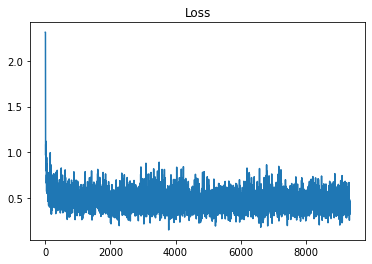

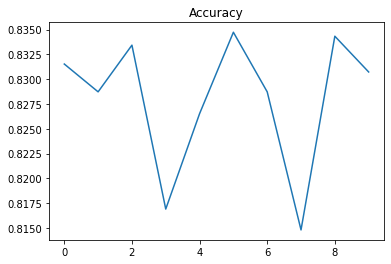

In [25]:
plt.plot(losses)
plt.title("Loss")
plt.show()

plt.plot(accuracies)
plt.title("Accuracy")
plt.show()

13 (Опционально) Постройте и обучите произвольную нейронную сеть с использованием Keras для решения той же задачи. 

In [26]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from keras.optimizers import Adam

In [27]:
keras_model = Sequential([
    Conv2D(filters=32, kernel_size=3, activation='relu', input_shape=(28, 28, 1)),
    MaxPooling2D(pool_size=2),
    Dropout(0.2),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(10, activation='softmax')
])

In [28]:
keras_model.compile(loss ='sparse_categorical_crossentropy', 
                    optimizer=Adam(lr=0.01),
                    metrics =['accuracy'])

/usr/local/lib/python3.7/dist-packages/keras/optimizers/optimizer_v2/adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [29]:
history = history = keras_model.fit(train_dataset,
    epochs=num_epochs,
    validation_data=test_dataset
)

Epoch 1/10
468/468 [==============================] - 29s 62ms/step - loss: 0.4688 - accuracy: 0.8338 - val_loss: 0.3513 - val_accuracy: 0.8757
Epoch 2/10
468/468 [==============================] - 29s 61ms/step - loss: 0.3225 - accuracy: 0.8839 - val_loss: 0.3237 - val_accuracy: 0.8850
Epoch 3/10
468/468 [==============================] - 29s 63ms/step - loss: 0.2948 - accuracy: 0.8928 - val_loss: 0.3059 - val_accuracy: 0.8925
Epoch 4/10
468/468 [==============================] - 28s 60ms/step - loss: 0.2700 - accuracy: 0.9015 - val_loss: 0.3196 - val_accuracy: 0.8846
Epoch 5/10
468/468 [==============================] - 28s 60ms/step - loss: 0.2662 - accuracy: 0.9034 - val_loss: 0.3188 - val_accuracy: 0.8915
Epoch 6/10
468/468 [==============================] - 28s 59ms/step - loss: 0.2516 - accuracy: 0.9091 - val_loss: 0.3076 - val_accuracy: 0.8944
Epoch 7/10
468/468 [==============================] - 28s 60ms/step - loss: 0.2426 - accuracy: 0.9105 - val_loss: 0.3260 - val_accuracy:

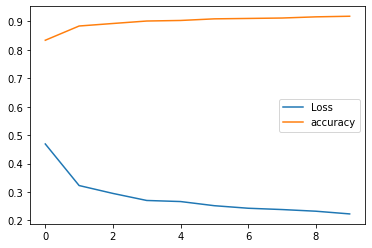

In [30]:
plt.plot(history.history['loss'], label="Loss")
plt.plot(history.history['accuracy'], label="accuracy")
plt.legend()